<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

##### 7th exercise: <font color="#C70039">Work with Variational Autoencoders (Generative Model)</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: Finn Heydemann
* Date:   07.11.2023

<img src="https://miro.medium.com/max/848/1*6uuK7GpIbfTb-0chqFwXXw.png" style="float: center;" width="400">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too.
* This applies to all exercises throughout this course.

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:
A Variational Autoencoder (VAE), instead of compressing its input image into a fixed code in the latent space (as the classic autoencoder does), turns the input image into the parameters of a statistical distribution: a mean and a variance.

This implies / imputes that the input image has been generated by a statistical process and that the randomness of this process should be taken into accounting during encoding and decoding. 

The VAE then uses the mean and variance parameters to randomly sample one element of that distribution, and decodes that element back to the original input. 

The stochasticity of this process improves robustness and forces the latent space to encode meaningful representations everywhere: every point sampled in the latent space is decoded to a valid output.


---------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time. 
    * try to understand each single step.
4. the notebooks code, especially keras is sometimes utilized a bit cumbersome. Try to optimize the code where you feel necessary.
5. experiment with different hyperparameters (search for the keyword 'task')
6. describe the three different loss curve plots. What do they show? Is this what you expected?
7. the main task is to visualize the latent space, the encoder has created. If you set high dimensions for the latent dim you can use T_SNE (plot 4).
8. describe the latent space with respect to its structure. Is this what you expected from a VAE?
---------------------------------

### VAEs
This code demonstrates a VAE using the MNIST dataset.
Just like a regular autoencoder a VAE returns an array (image) of same dimensions as the input but variation can be introduced by tweaking the so-called latent vector.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from   tensorflow.keras import layers, models, losses, metrics, optimizers
from   tensorflow.keras.datasets import mnist

2023-11-12 13:31:04.734063: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Model: "Encoder"
Create an encoder model with the following properties:


In [2]:
# _____________________________________________________________________________
#  Layer (type)                 Output Shape         Activation     Input      
# =============================================================================
#  encoder_input (InputLayer)       [(None, 28, 28, 1)]  None           
#  encoder_flatten (Flatten)        (None, 784)          None           enc_input
#  encoder_dense_1 (Dense)          (None, 2000)         ReLU           enc_flatten
#  encoder_dense_2 (Dense)          (None, 256)          ReLU           enc_dense_1
#  z_mean (Dense)                   (None, 2)            None           enc_dense_2
#  z_log_var (Dense)                (None, 2)            None           enc_dense_2

def make_encoder(latent_dim:int = 2):
    encoder_input = layers.Input(shape=(28,28,1), dtype='float32')
    encoder_flatten = layers.Flatten(name = 'flat')(encoder_input)
    encoder_dense_1 = layers.Dense(units = 2000, activation = 'relu', name = 'dense_1')(encoder_flatten)
    encoder_dense_2 = layers.Dense(units = 256, activation = 'relu', name = 'dense_2')(encoder_dense_1)
    z_mean = layers.Dense(units = latent_dim, name = 'latent_mean')(encoder_dense_2)
    z_log_var  = layers.Dense(units = latent_dim, name = 'latent_log_var')(encoder_dense_2)

    encoder = models.Model(inputs = encoder_input, outputs = (z_mean, z_log_var), name = 'encoder')
    return encoder

make_encoder().summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 flat (Flatten)                 (None, 784)          0           ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 2000)         1570000     ['flat[0][0]']                   
                                                                                                  
 dense_2 (Dense)                (None, 256)          512256      ['dense_1[0][0]']                
                                                                                            

2023-11-12 13:31:10.326475: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### Model: "decoder"
Create a decoder model with the following properties:

In [117]:
# _____________________________________________________________________________
#  Layer (type)                Output Shape          Activation     Input
# =============================================================================
#  decoder_input (InputLayer)      [(None, 2)]           None
#  decoder_dense_1 (Dense)         (None, 256)           ReLU           dec_input
#  decoder_dense_2 (Dense)         (None, 2000)          ReLU           dec_dense_1
#  decoder_dense_3 (Dense)         (None, 784)           Sigmoid        dec_dense_2
#  img_out (Reshape)               (None, 28, 28, 1)     None           des_dense_3

def make_decoder(latent_dim:int = 2):
    decoder_input = layers.Input(shape=(latent_dim,), dtype='float32')
    decoder_dense_1 = layers.Dense(units = 256, activation = 'relu', name = 'dec_dense_1')(decoder_input)
    decoder_dense_2 = layers.Dense(units = 2000, activation = 'relu', name = 'dec_dense_2')(decoder_dense_1)
    decoder_dense_3 = layers.Dense(units = 784, activation = 'sigmoid', name = 'dec_dense_3')(decoder_dense_2)
    img_out = layers.Reshape((28,28,1), name = 'img_out')(decoder_dense_3)

    decoder = models.Model(inputs = decoder_input, outputs = img_out, name = 'decoder')
    return decoder

make_decoder().summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 2)]               0         
                                                                 
 dec_dense_1 (Dense)         (None, 256)               768       
                                                                 
 dec_dense_2 (Dense)         (None, 2000)              514000    
                                                                 
 dec_dense_3 (Dense)         (None, 784)               1568784   
                                                                 
 img_out (Reshape)           (None, 28, 28, 1)         0         
                                                                 
Total params: 2,083,552
Trainable params: 2,083,552
Non-trainable params: 0
_________________________________________________________________


In [4]:
# class 'latent_sampling', which subclasses layers.Layer.
# The class should perform the reparameterisation trick in its .call() method.

'''---------------------------------------------------------------------------'''
# Reparameterization Trick: z = mean + epsilon * exp(ln(variance) * 0.5)
# epsilon = N(0,1), a unit normal with same dims as mean and variance
'''---------------------------------------------------------------------------'''
class latent_sampling(layers.Layer):
    
    def call(self, z_mean, z_log_var):
        tf.keras.layers.Layer(trainable = True)
        self.batch = tf.shape(z_mean)[0]
        self.dim = tf.shape(z_mean)[1]
        self.epsilon = tf.keras.backend.random_normal(shape=(self.batch, self.dim))
        self.z =  z_mean + self.epsilon * tf.exp(z_log_var * 0.5)

        return self.z

In [5]:
# Loss functions

# Modified loss function for the model. The standard binary cross entropy
# takes a mean over all pixels in all images, but the VAE needs the
# reconstruction loss to be the sum of the pixel-wise losses, averaged over
# samples in the batch. Otherwise the reconstruction loss is becoming too small.

def recon_loss(y_true, y_pred):
    loss = tf.reduce_sum(losses.binary_crossentropy(y_true, y_pred),axis=(1, 2))
    return loss

# Method that calculates the Kullback-Liebler divergence between the
# posterier distribution, N(mean, variance), and the prior, N(0,1).
# Can be added to the model as a loss or metric, using self.add_loss and
# self.add_metric


def kl_loss(mean, logvar): 
    # Calculate the element wise KL divergence
    kl = -0.5 * (1 + logvar - tf.square(mean) - tf.exp(logvar))
    # Sum up the divergence of all the variables in each data sample
    kl = tf.reduce_sum(kl, axis=1)
    # Average the divergence across all samples in the batch
    kl = tf.reduce_mean(kl)
    return kl

In [6]:
### The 'VAE' Class. 
### The __init__ method—which will set up the layers and submodels—and the call() method.

class VAE(tf.keras.Model):
    """
    A Keras Model that implements a Variational Autoencoder. Model properties
    should include the encoder and decoder models, a sampling layer, and the
    number of latent variables in the encoded space.
    """
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        """
        Take in model properties and assign them to self.
        """
        # self.latent_dim = latent_dim
        self.encoder = make_encoder(latent_dim)
        self.sampling = latent_sampling()
        self.decoder = make_decoder(latent_dim)
        
    def encode(self, x):
        """
        Method that applies the encoder model to input data. Returns the mean
        and ln(variance) of the encoded variables.
        """
        mean, logvar = self.encoder(x)
        return mean, logvar

    def decode(self, z):
        """
        Method that applies the decoder model to a set of encoded variables.
        Returns the generated images from the encoded data.
        """
        x_hat = self.decoder(z)
        return x_hat
        

    def call(self, inputs):
        """
        Apply the encoder, sampling layer and decoder to the input data. Add
        the kl divergence to the model losses and metrics. Return the generated
        image.
        """
        z_mean, z_log_var = self.encoder(inputs)
        sampled_output = self.sampling(z_mean, z_log_var)
        output = self.decoder(sampled_output)
        kll = kl_loss(z_mean, z_log_var)
        self.add_loss(kll)
        self.add_metric(kll, name = 'kl_loss_metric')
        return output


In [7]:
# Create the VAE model, using your encoder and decoder models. 
# Compile the model with appropriate optimizer settings, losses and metrics.
'''
(TASK: don't be afraid to experiment with different settings here (e.g. latent_dim))
'''
autoencoder = VAE(latent_dim = 2)

# Default learning rate, optimizer = nAdam.
autoencoder.compile(tf.keras.optimizers.Nadam(),loss = recon_loss,
                    metrics = [recon_loss, 'accuracy'])

In [8]:
# Load the MNIST data set
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Function to preprocess the data 
def preprocessing(image):
    image =  tf.expand_dims(image, -1)
    image =  tf.image.random_flip_left_right(image)
    image  = tf.image.convert_image_dtype(image, 'float32')

    return image, image

# Slice off the training data
dataset = tf.data.Dataset.from_tensor_slices(x_train)

# Preparing the data for training 
final_dataset = dataset.shuffle(1000).batch(64, drop_remainder=True).map(preprocessing)

### Train the model
Train the model on the images from the training set until the losses converge.
"history = model.fit" allows for storing the training and validation losses in a dictionary so they can be visualized later.

In [9]:
history = autoencoder.fit(final_dataset, batch_size = 256, epochs =30)
history.history.keys()  

Epoch 1/30


2023-11-12 13:31:22.225001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype uint8 and shape [60000,28,28]
	 [[{{node Placeholder/_0}}]]
2023-11-12 13:31:22.225202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype uint8 and shape [60000,28,28]
	 [[{{node Placeholder/_0}}]]


937/937 [==============================] - 66s 69ms/step - loss: 179.0531 - recon_loss: 174.0953 - accuracy: 0.7933 - kl_loss_metric: 4.9577
Epoch 2/30
937/937 [==============================] - 73s 78ms/step - loss: 164.7108 - recon_loss: 159.3563 - accuracy: 0.7940 - kl_loss_metric: 5.3546
Epoch 3/30
937/937 [==============================] - 74s 79ms/step - loss: 161.3074 - recon_loss: 155.6889 - accuracy: 0.7941 - kl_loss_metric: 5.6185
Epoch 4/30
937/937 [==============================] - 78s 83ms/step - loss: 159.4656 - recon_loss: 153.7300 - accuracy: 0.7942 - kl_loss_metric: 5.7355
Epoch 5/30
937/937 [==============================] - 73s 78ms/step - loss: 158.1885 - recon_loss: 152.3201 - accuracy: 0.7944 - kl_loss_metric: 5.8684
Epoch 6/30
937/937 [==============================] - 75s 80ms/step - loss: 156.9903 - recon_loss: 150.9901 - accuracy: 0.7947 - kl_loss_metric: 6.0003
Epoch 7/30
937/937 [==============================] - 71s 76ms/step - loss: 156.0195 - recon_loss: 

dict_keys(['loss', 'recon_loss', 'accuracy', 'kl_loss_metric'])

### Visualize the results (plot 1)
Create plots that show the losses and metrics, the reconstruction quality of
the trained network, and the generative quality of the network. 

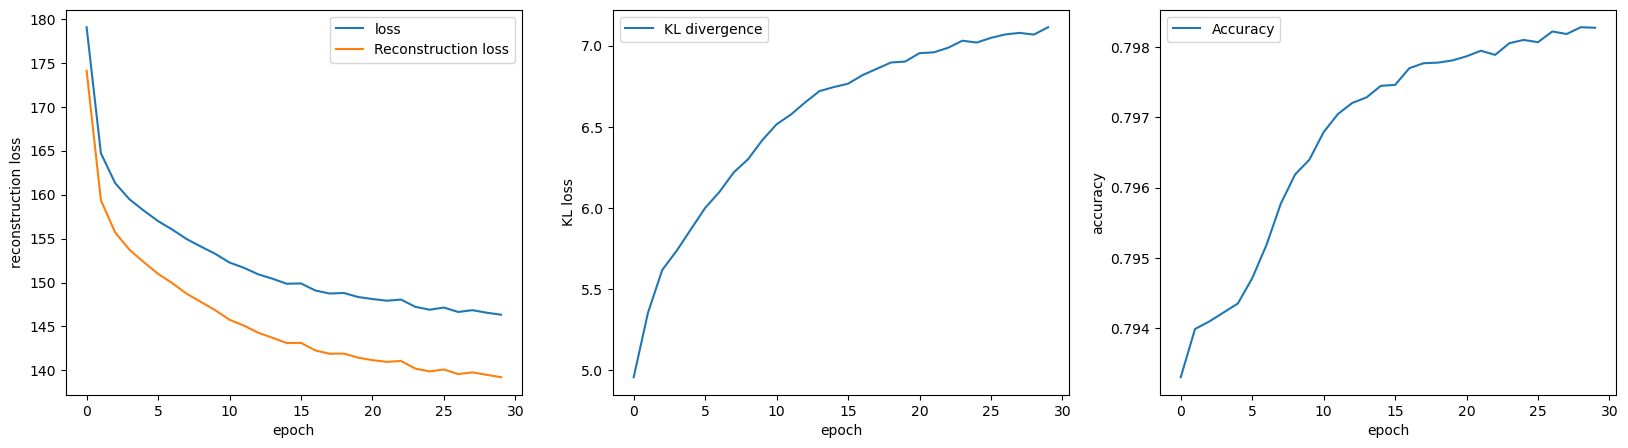

In [10]:
f, ax = plt.subplots(1,3, figsize = (20,5))

ax[0].plot(history.history['loss'], label = 'loss')
ax[0].plot(history.history['recon_loss'], label = 'Reconstruction loss')
ax[0].set_ylabel('reconstruction loss')
ax[0].set_xlabel('epoch')
ax[0].legend()

ax[1].plot(history.history['kl_loss_metric'], label = 'KL divergence')
ax[1].set_ylabel('KL loss')
ax[1].set_xlabel('epoch')
ax[1].legend()

ax[2].plot(history.history['accuracy'], label = 'Accuracy')
ax[2].set_ylabel('accuracy')
ax[2].set_xlabel('epoch')
ax[2].legend()

plt.show()

### Prediction of test data (plot 2)

313/313 [==============================] - 12s 37ms/step


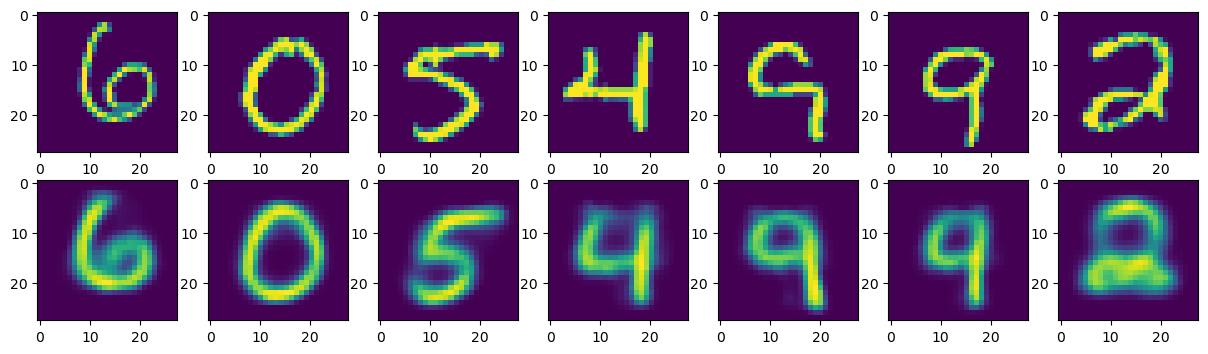

In [11]:
predict = autoencoder.predict(x_test/255.)
f, ax = plt.subplots(2, 7, figsize = (15,4))

# Testing the reconstruction quality of the network using the Test Images 
for i in range(7):
    ax[0,i].imshow(x_test[i+100])
    ax[1,i].imshow(predict[i+100,:,:,0])

### Testing the generative quality of the network (plot 3)

In [12]:
x_axis = np.linspace(-1, 1, 10)
y_axis = np.linspace(-1, 1, 10)
figure = np.zeros((28 * 10, 28 * 10))

# loop through each number for decoding
for i_x, x in enumerate(x_axis):
    for i_y, y in enumerate(y_axis):
        latent = np.array([[x, y]])
        print(latent.shape)
        generated_image = autoencoder.decoder.predict(latent)[0] # decode the numbers
        figure[i_x*28:(i_x+1)*28, i_y*28:(i_y+1)*28,] = generated_image[:,:,-1]

(1, 2)
1/1 [==============================] - 0s 37ms/step
(1, 2)
1/1 [==============================] - 0s 23ms/step
(1, 2)
1/1 [==============================] - 0s 61ms/step
(1, 2)
1/1 [==============================] - 0s 20ms/step
(1, 2)
1/1 [==============================] - 0s 22ms/step
(1, 2)
1/1 [==============================] - 0s 23ms/step
(1, 2)
1/1 [==============================] - 0s 58ms/step
(1, 2)
1/1 [==============================] - 0s 29ms/step
(1, 2)
1/1 [==============================] - 0s 68ms/step
(1, 2)
1/1 [==============================] - 0s 21ms/step
(1, 2)
1/1 [==============================] - 0s 58ms/step
(1, 2)
1/1 [==============================] - 0s 28ms/step
(1, 2)
1/1 [==============================] - 0s 53ms/step
(1, 2)
1/1 [==============================] - 0s 30ms/step
(1, 2)
1/1 [==============================] - 0s 23ms/step
(1, 2)
1/1 [==============================] - 0s 34ms/step
(1, 2)
1/1 [==============================] - 0s 64ms/st

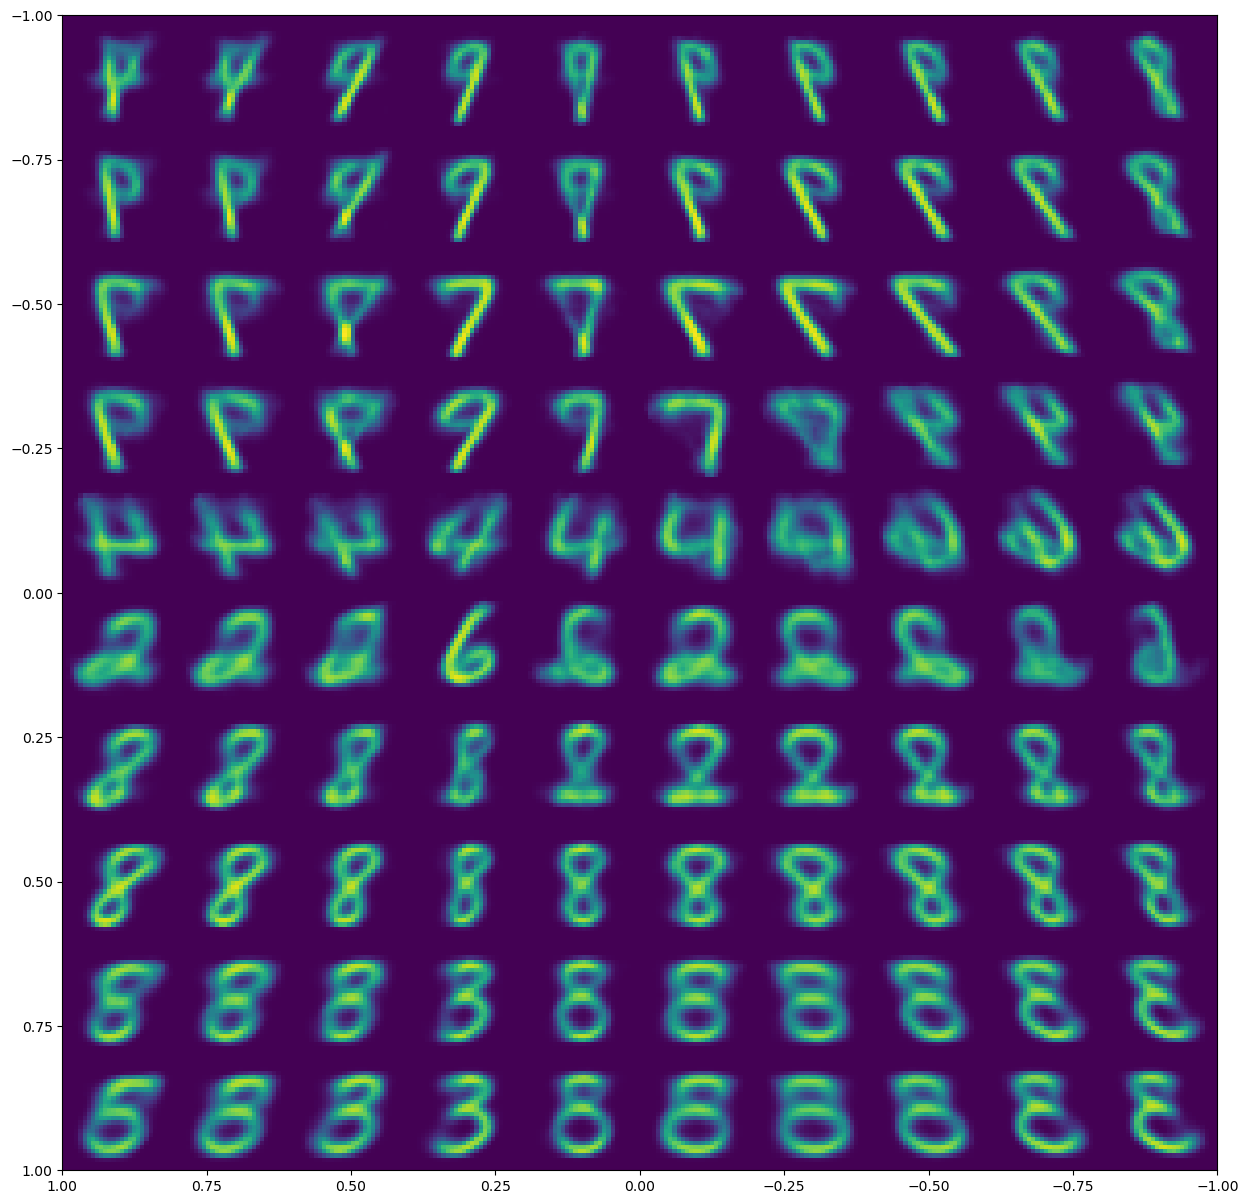

In [13]:
plt.figure(figsize=(15, 15))
plt.imshow(figure, extent=[1,-1,1,-1])
plt.show()

### Task: Visualize the latent space (if latent_dim > 2 then by using T_SNE) (plot 4)
#### Describe the latent space with respect to its structure. 

Remember: t-SNE is stochastic and therefore the results may appear slightly different every time it is re-run. So don't worry.


In [14]:
# add your code section here !

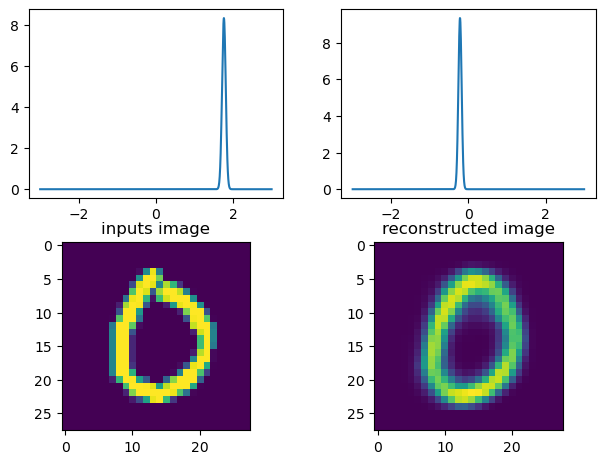

In [15]:
from scipy import stats

index = 612
img = (x_train / 255)[index:index+1]

enc = autoencoder.encoder(img)
fig, axs = plt.subplots(2, 2)
fig.tight_layout()

for ax, (mu, logvar) in zip(axs.flatten(), np.stack([e.numpy().reshape(-1) for e in enc]).T): 
    x = np.linspace(-3, 3, 1000)
    sigma = np.exp(logvar * .5)
    ax.plot(x, stats.norm.pdf(x, mu, sigma))

axs[1, 0].set_title("inputs image")
axs[1, 0].imshow(img[0])

sampled_data = latent_sampling().call(*enc)
axs[1, 1].set_title("reconstructed image")
axs[1, 1].imshow(autoencoder.decoder(sampled_data)[0, :, :, 0])
plt.show()

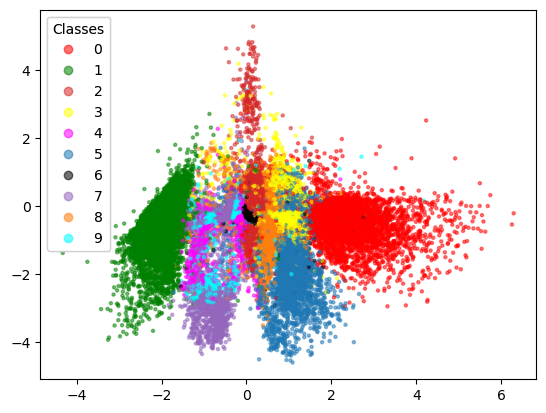

In [139]:
from matplotlib.colors import ListedColormap

def make_scatter_plot(mu, y_train, **scater_kwargs): 
    fig, ax = plt.subplots()
    colormap = ListedColormap(["red", "green", "tab:red", "yellow", "magenta", "tab:blue", "black", "tab:purple", "tab:orange", "cyan"])

    scatter = ax.scatter(*np.array(mu).T, c=y_train, 
                         cmap=colormap, 
                         **scater_kwargs)

    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="best", title="Classes")
    ax.add_artist(legend1)
    return fig, ax

mu, logvar = autoencoder.encoder(x_train / 255)
fig, ax = make_scatter_plot(mu, y_train, s=5, alpha=.5)
plt.show()

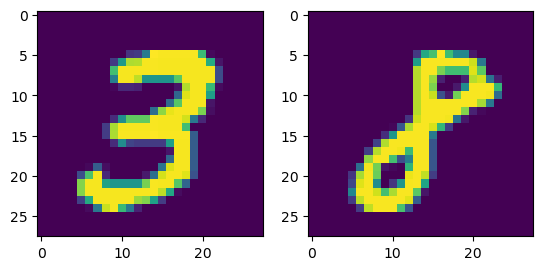

In [133]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(x_train[7])
axs[1].imshow(x_train[31])

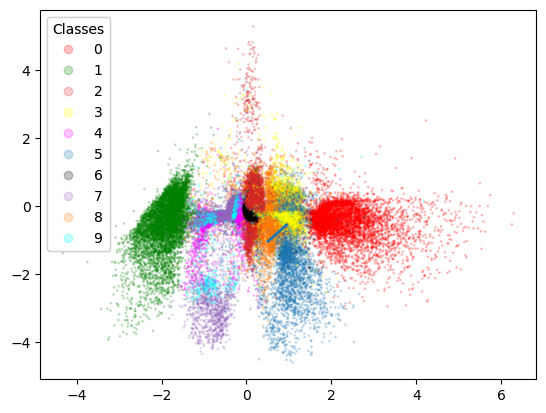

In [140]:
mu3, logvar3 = autoencoder.encoder(x_train[7:8] / 255)
mu8, logvar8 = autoencoder.encoder(x_train[31:32] /255)

mu, logvar = autoencoder.encoder(x_train / 255)
fig, ax = make_scatter_plot(mu, y_train, alpha=.2, s=1)
ax.plot(*np.stack([mu3, mu8])[:, 0, :].T, lw=2)
plt.show()

In [141]:
vec38 = mu8 - mu3
length = np.linalg.norm(vec38)
mu3, vec38, length

(<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.9441233, -0.5535704]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.43516874, -0.4810629 ]], dtype=float32)>,
 0.6486859)

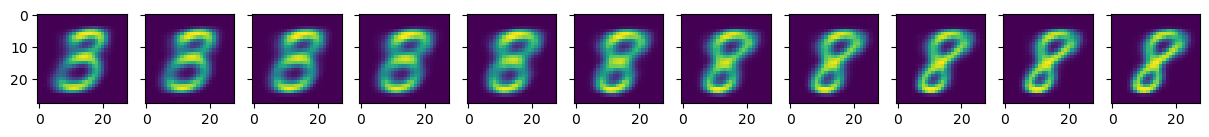

In [142]:
# transform 3 to an 8 
steps = 10
fig, axs = plt.subplots(1, steps + 1, sharey=True, figsize=(15, 6))

for i in range(steps + 1): 
    axs[i].imshow(autoencoder.decode(mu3 + vec38 * (i / steps))[0, :, :, 0] * 255)

In [35]:
class SimpleVAE(VAE): 
    
    def __init__(self, latent_dim):
        super().__init__(latent_dim)
        
    def call(self, inputs): 
        z_mean, z_log_var = self.encoder(inputs)
        sampled_output = self.sampling(z_mean, z_log_var)
        output = self.decoder(sampled_output)
        return output
    
autoencoder_rl = SimpleVAE(2)
autoencoder_rl.compile(tf.keras.optimizers.Nadam(),loss = recon_loss, metrics=["accuracy", recon_loss])
autoencoder_rl.fit(final_dataset, batch_size=256, epochs=30)

In [143]:
mu, logvar = autoencoder_rl.encoder(x_train / 255)
fig, ax = make_scatter_plot(mu, y_train, s=5, alpha=.5)

NameError: name 'autoencoder_rl' is not defined

In [39]:
autoencoder_kl = VAE(2)
autoencoder_kl.compile(tf.keras.optimizers.Nadam(), loss= lambda x, y: 0, metrics=["accuracy"])
autoencoder_kl.fit(final_dataset, batch_size=256, epochs=8)

Epoch 1/5
937/937 [==============================] - 44s 47ms/step - loss: 0.0030 - accuracy: 0.4078 - kl_loss_metric: 0.0030
Epoch 2/5
937/937 [==============================] - 45s 48ms/step - loss: 1.4476e-05 - accuracy: 0.4078 - kl_loss_metric: 1.4476e-05
Epoch 3/5
937/937 [==============================] - 29s 31ms/step - loss: 6.6666e-06 - accuracy: 0.4079 - kl_loss_metric: 6.6666e-06
Epoch 4/5
937/937 [==============================] - 47s 50ms/step - loss: 3.3635e-06 - accuracy: 0.4078 - kl_loss_metric: 3.3635e-06
Epoch 5/5
937/937 [==============================] - 44s 47ms/step - loss: 1.8899e-06 - accuracy: 0.4078 - kl_loss_metric: 1.8899e-06


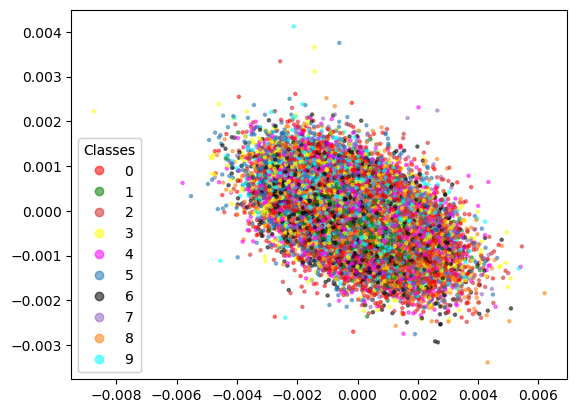

In [39]:
mu, logvar = autoencoder_kl.encoder(x_train / 255)
fig, ax = make_scatter_plot(mu, y_train, s=5, alpha=.5)
plt.show()

In [115]:
from sklearn.manifold import TSNE

In [118]:
autoencoder3d = VAE(3)

autoencoder3d.compile(tf.keras.optimizers.Nadam(),loss = recon_loss, metrics = [recon_loss, 'accuracy'])
autoencoder3d.fit(final_dataset, batch_size = 256, epochs =30)

Epoch 1/20
937/937 [==============================] - 58s 61ms/step - loss: 167.6458 - recon_loss: 160.9583 - accuracy: 0.7938 - kl_loss_metric: 6.6876
Epoch 2/20
937/937 [==============================] - 68s 73ms/step - loss: 152.8630 - recon_loss: 145.5846 - accuracy: 0.7967 - kl_loss_metric: 7.2783
Epoch 3/20
937/937 [==============================] - 73s 78ms/step - loss: 148.2283 - recon_loss: 140.5122 - accuracy: 0.7979 - kl_loss_metric: 7.7160
Epoch 4/20
937/937 [==============================] - 80s 86ms/step - loss: 145.2717 - recon_loss: 137.2673 - accuracy: 0.7985 - kl_loss_metric: 8.0044
Epoch 5/20
937/937 [==============================] - 81s 86ms/step - loss: 143.1972 - recon_loss: 135.0064 - accuracy: 0.7990 - kl_loss_metric: 8.1909
Epoch 6/20
937/937 [==============================] - 77s 82ms/step - loss: 141.7401 - recon_loss: 133.3902 - accuracy: 0.7994 - kl_loss_metric: 8.3497
Epoch 7/20
937/937 [==============================] - 77s 82ms/step - loss: 140.5084 - r

In [156]:
mu, logvar = autoencoder3d.encoder(x_train / 255)
mu = mu.numpy()
mu.shape

(60000, 3)

In [158]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(mu)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.018s...
[t-SNE] Computed neighbors for 60000 samples in 0.818s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for sam

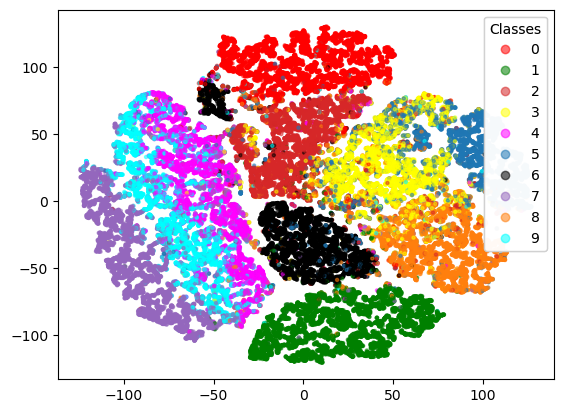

In [175]:
fig, ax = make_scatter_plot(z, y_train, s=5, alpha=.5)
plt.show()

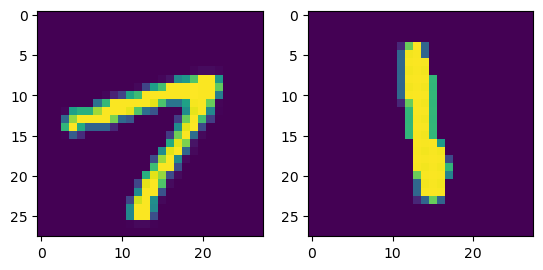

In [178]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(x_train[101])
axs[1].imshow(x_train[200])

In [183]:
mu7, _ = autoencoder3d.encoder(x_train[101:102] / 255)
mu1, _ = autoencoder3d.encoder(x_train[200:201] / 255)
mu1, mu7

(<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.6485219 , -1.6041871 ,  0.32964644]], dtype=float32)>,
 <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0.7290039,  0.8715612, -1.9652699]], dtype=float32)>)

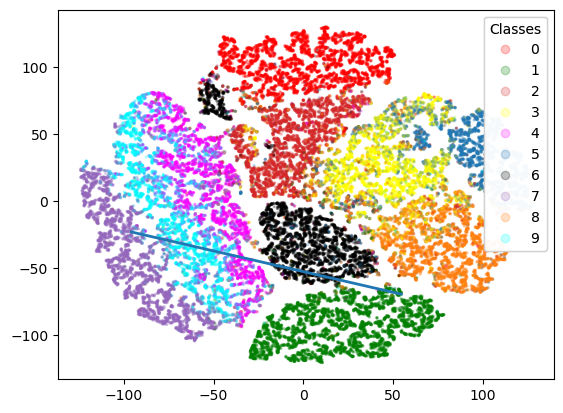

In [219]:
fig, ax = make_scatter_plot(z, y_train, s=2, alpha=.2)
ax.plot(*np.stack((z[101], z[200])).T, lw=2)
plt.show()

In [227]:
vec71 = mu1 - mu7 
length = np.linalg.norm(vec71)
vec71, length

(<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-1.3775258, -2.4757483,  2.2949164]], dtype=float32)>,
 3.6460319)

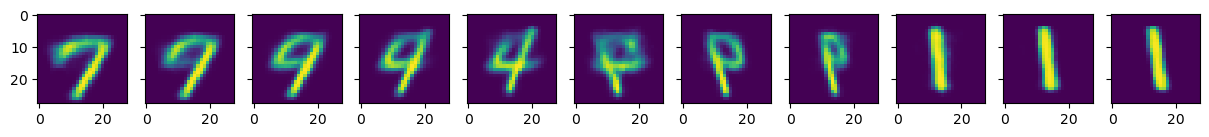

In [243]:
steps = 10
fig, axs = plt.subplots(1, steps + 1, figsize=(15, 6), sharey=True)
for ax, step in zip(axs, range(steps + 1)): 
    ax.imshow(autoencoder3d.decode(mu7 + vec71 * (step / steps))[0, :, :, 0])